In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

# modelos de machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Fórmulas e arquivos auxiliares
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
    metricas_grid_search
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int8  
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int16 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int8  
 6   Education                 1470 non-null   int8  
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int8  
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int8  
 11  JobInvolvement            1470 non-null   int8  
 12  JobLevel                  1470 non-null   int8  
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

#### Separação das colunas da Análise Exploratória

In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

colunas_numericas

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

#### Separação das colunas numéricas de acordo com a transformação que vão passar

In [5]:
colunas_numericas_min_max = [                                             # Sâo colunas que parecem ter uma distribuição uniforme
    "DailyRate",
    "HourlyRate",
    "MonthlyRate",
]

colunas_numericas_std = ["Age",]                                          # Já possui distribuição normal, vamos usar o StandardScaler

colunas_numericas_power_transform = [                                     # Colunas numéricas que possui distribuição assimétrica (nem uniforme e nem normal)
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

colunas_numericas_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


#### Tranformando coluna do target para numérica

In [8]:
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())

y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [9]:
le.classes_

array(['No', 'Yes'], dtype=object)

#### Definindo os Folds para validação cruzada

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Definindo Preprocessamento

In [11]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas)
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
        ('min_max', MinMaxScaler(), colunas_numericas_min_max),
        ('stdscaler', StandardScaler(), colunas_numericas_std),
        ('power_transform', PowerTransformer(), colunas_numericas_power_transform),
    ]
)

#### Dicionário de Classificadores

- *Balanceamento das classes*: Será usado o parametro class_weight='balanced' ou scale_pos_weight=scale_pos_weight para que os modelos que serão treinados levem em consideração o desbalanceamento das classes.

In [12]:
scale_pos_weight = (np.bincount(y)[0]/ np.bincount(y)[1])
scale_pos_weight

# É bom fazer essa etapa antes para ver o resultado, se a classe é desbalanceada e possui menos registros positivos, o valor deve ser maior do que 1 (somatório de registros de classe 0 / classe 1)

5.2025316455696204

In [13]:
classificadores = {
    'DummyClassifier': {
        'classificador' : DummyClassifier(),
        'preprocessor' : None
    },

    # modelos lineares
    'LogisticRegression': {
        'classificador' : LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
        'preprocessor' : preprocessamento
    },

    # modelos de árvore de decisão
    'DecisionTree': {
        'classificador' : DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
        'preprocessor' : preprocessamento_arvore
    },
    'LightGBM': {                                                                          
        'classificador' : LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1, scale_pos_weight=scale_pos_weight),      # Poderia usar o is_unbalance=True em vez do scale_pos_weight
        'preprocessor' : preprocessamento_arvore
    },       
    'XGBoost': {
        'classificador' : XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight),
        'preprocessor' : preprocessamento_arvore
    },   

    #kNN
    'KNeighboursClassifier': {
        'classificador' : KNeighborsClassifier(),
        'preprocessor' : preprocessamento
    },

    #SVC
    'SVC': {
        'classificador' : SVC(random_state=RANDOM_STATE, class_weight='balanced'),
        'preprocessor' : preprocessamento
    },   
}

#### Treinando e Testando Modelos de Classificação

In [14]:
resultados = {nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **modelo) 
              for nome_modelo, modelo in classificadores.items()}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.001995,0.023692,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.025687
1,DummyClassifier,0.001996,0.014957,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.016953
2,DummyClassifier,0.000996,0.017241,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.018236
3,DummyClassifier,0.002005,0.017039,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.019044
4,DummyClassifier,0.001,0.012964,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.013963
5,LogisticRegression,0.216971,0.029526,0.738095,0.726118,0.468966,0.350515,0.708333,0.815803,0.562719,0.246497
6,LogisticRegression,0.070013,0.037876,0.768707,0.752795,0.507246,0.388889,0.729167,0.836636,0.619674,0.107889
7,LogisticRegression,0.057758,0.033277,0.758503,0.761521,0.503497,0.375,0.765957,0.838229,0.650953,0.091035
8,LogisticRegression,0.066734,0.047865,0.789116,0.77974,0.537313,0.413793,0.765957,0.842622,0.651174,0.114599
9,LogisticRegression,0.078321,0.050413,0.772109,0.75239,0.503704,0.386364,0.723404,0.787062,0.580918,0.128734


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Queremos saber o que levo os funcionários a sair da empresa (Attrition)
- Também é importante querer saber o que faz os funcionários ficarem na empresa
- Ou seja, podemos usar uma métrica que faça o balanceamento entre precision e recall
- Logo, vamos o usar o average_precision (poderíamos usar o f1 também)

In [15]:
df_resultados.groupby(by='model').mean().sort_values(by='test_average_precision', ascending=True)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001598,0.017178,0.838776,0.5,0.0,0.0,0.0,0.5,0.161224,0.018777
DecisionTree,0.02526,0.033622,0.783673,0.603238,0.332944,0.329691,0.337057,0.603238,0.220891,0.058882
KNeighboursClassifier,0.061032,0.149925,0.848299,0.549917,0.186511,0.734359,0.109574,0.667141,0.31623,0.210957
XGBoost,0.071304,0.031595,0.826531,0.664686,0.441594,0.459649,0.425887,0.777781,0.468712,0.102899
LightGBM,0.103983,0.040053,0.823129,0.684999,0.467428,0.454588,0.481117,0.79295,0.497247,0.144036
LogisticRegression,0.09796,0.039791,0.765306,0.754513,0.504145,0.382912,0.738564,0.82407,0.613087,0.137751
SVC,0.117067,0.09431,0.821088,0.755393,0.543927,0.464096,0.658422,0.832352,0.613854,0.211378


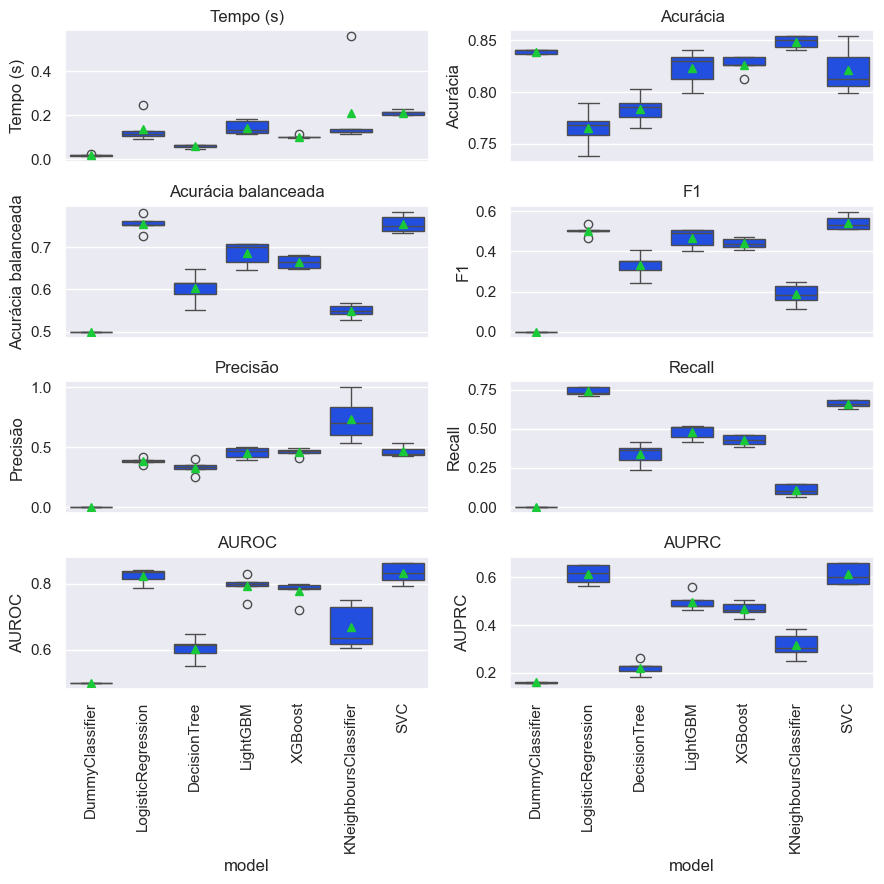

In [16]:
plot_comparar_metricas_modelos(df_resultados)

#### Escolher modelo para otimização: *LogisticRegression*
- Os melhores modelos foram LogisticRegression e SVC
- Mas o SVC é mais lento, possui interpretação mais complexa e recall menor quando comparado com LogisticRegression
- Podemos fazer um segundo grid_search usando o SVC para comparar os resultados dos 2 modelos otimizados caso acharmos necessário posteriormente.

#### Testando diferentes parâmetros no melhor modelo

In [17]:
param_grid = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', None],                # Regularização
    'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],                        # Apenas se o modelo for elastic_net
    'clf__C': [0.01, 0.1, 1, 10],    
    'clf__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    #'clf__class_weight': [None, 'balanced']                         # Podemos tirar do grid_search e já deixar dentro do modelo, será uma variável a menos pra ser analisada
}

#### Rodando a função do GridSearchCV

In [18]:
clf = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

grid_search = grid_search_cv_classificador(
    clf,
    param_grid=param_grid,
    cv=kf,
    preprocessor=preprocessamento,
    refit_metric='average_precision'
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [19]:
grid_search.fit(X,y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
600 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brcprrcchave\AppData\Local\anaconda

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [20]:
grid_search.best_score_            # Aumentou de 0.62 do LogisticRegression simples para 0.634 agora

0.6349983962539747

In [21]:
grid_search.best_params_

{'clf__C': 0.1,
 'clf__l1_ratio': 0.5,
 'clf__penalty': 'elasticnet',
 'clf__solver': 'saga'}

**OBS:** Veja que tivemos penalty='elasticnet' indicando que houve sim regularização do modelo, ou seja, algumas features do modelo tiveram seu coeficiente zerado.

#### Obtendo as Outras Métricas do grid_search.best_estimator

In [ ]:
# grid_search.cv_results_        # Para ver o resultado de TODAS AS MÉTRICAS de TODOS MODELOS formados com o GRID_SEARCH

{'mean_fit_time': array([0.12026348, 0.15671296, 0.12007051, 0.11822724, 0.12683721,
        0.18126326, 0.12057519, 0.13235826, 0.10597663, 0.16421251,
        0.11874971, 0.11089072, 0.10269608, 0.2646091 , 0.14879417,
        0.16967025, 0.11198583, 0.13500824, 0.11347241, 0.11351891,
        0.10369563, 0.17394543, 0.12640505, 0.12370243, 0.10299253,
        0.15661473, 0.11011419, 0.11494651, 0.1004869 , 0.29196734,
        0.13301015, 0.16143618, 0.10563951, 0.1317162 , 0.10547338,
        0.09863048, 0.10347624, 0.14608736, 0.1074481 , 0.11006966,
        0.0953526 , 0.13659196, 0.09466801, 0.10150452, 0.1079565 ,
        0.22772279, 0.13741269, 0.15471344, 0.10385237, 0.13412595,
        0.10243015, 0.09940815, 0.11169381, 0.16357703, 0.11513066,
        0.11661158, 0.09703822, 0.13763528, 0.09341192, 0.09986334,
        0.09159827, 0.2477365 , 0.14895029, 0.16528163, 0.11194839,
        0.13885455, 0.09996991, 0.10491509, 0.11079602, 0.16308684,
        0.12229257, 0.1346673 ,

In [23]:
grid_search.cv_results_.keys()     

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__l1_ratio', 'param_clf__penalty', 'param_clf__solver', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_tes

In [24]:
metricas = []

for metrica in grid_search.cv_results_.keys():
    if metrica.startswith('mean'):
        metricas.append(metrica)

metricas

['mean_fit_time',
 'mean_score_time',
 'mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [25]:
grid_search.best_index_         # O melhor modelo de todos do grid_search foi o de índice 105

121

In [26]:
grid_search.cv_results_['mean_test_average_precision']

array([0.3427236 , 0.33362789,        nan,        nan, 0.60619873,
       0.6130884 , 0.61319247, 0.61309176,        nan, 0.6130884 ,
              nan,        nan,        nan, 0.60276858, 0.6018157 ,
       0.60036961, 0.3427236 , 0.33362789,        nan,        nan,
       0.60619873, 0.6130884 , 0.61319247, 0.61309176,        nan,
       0.5714853 ,        nan,        nan,        nan, 0.60276858,
       0.6018157 , 0.60036961, 0.3427236 , 0.33362789,        nan,
              nan, 0.60619873, 0.6130884 , 0.61319247, 0.61309176,
              nan, 0.50751199,        nan,        nan,        nan,
       0.60276858, 0.6018157 , 0.60036961, 0.3427236 , 0.33362789,
              nan,        nan, 0.60619873, 0.6130884 , 0.61319247,
       0.61309176,        nan, 0.41704794,        nan,        nan,
              nan, 0.60276858, 0.6018157 , 0.60036961, 0.3427236 ,
       0.33362789,        nan,        nan, 0.60619873, 0.6130884 ,
       0.61319247, 0.61309176,        nan, 0.33362789,        

In [27]:
grid_search.cv_results_['mean_test_average_precision'][grid_search.best_index_]      # Veja que é o mesmo score obtido pelo grid_search.best_score_

0.6349983962539747

In [28]:
coluna_test = [coluna for coluna in df_resultados.columns if coluna.startswith('test')]
coluna_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [29]:
colunas_test_mean = ['mean_' + coluna for coluna in coluna_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [30]:
for coluna in colunas_test_mean:
    print(f'{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}')

mean_test_accuracy: 0.7605442176870748
mean_test_balanced_accuracy: 0.7482709483180627
mean_test_f1: 0.49647644086126974
mean_test_precision: 0.3765470961861631
mean_test_recall: 0.7301418439716312
mean_test_roc_auc: 0.8237225183432815
mean_test_average_precision: 0.6349983962539747


In [31]:
metricas_grid_search(grid_search)

mean_fit_time: 0.29850234985351565
mean_score_time: 0.07400994300842285
mean_test_accuracy: 0.7605442176870748
mean_test_balanced_accuracy: 0.7482709483180627
mean_test_f1: 0.49647644086126974
mean_test_precision: 0.3765470961861631
mean_test_recall: 0.7301418439716312
mean_test_roc_auc: 0.8237225183432815
mean_test_average_precision: 0.6349983962539747


#### Analisando coeficientes das features de maior importância pro modelo

In [32]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
ordinal__JobInvolvement,-0.408202
power_transform__MonthlyIncome,-0.400248
one_hot__Department_Research & Development,-0.339218
ordinal__EnvironmentSatisfaction,-0.327133
ordinal__JobSatisfaction,-0.296962
power_transform__TotalWorkingYears,-0.288454
power_transform__YearsInCurrentRole,-0.229396
power_transform__YearsWithCurrManager,-0.226763
min_max__DailyRate,-0.217531
ordinal__WorkLifeBalance,-0.205558


- Podemos perceber que tem alguns coeficientes zerados (foi obtido devido parametros de regularização), e indica algumas informações que não fazem diferença pro Attrition.
- Posso voltar pra análise exploratória pra deixar o projeto mais detalhado, já sabendo quais features que não devo me preocupar em maior detalhamento, pois não influencia o Attrition.

In [33]:
coefs.query('coeficiente == 0')

,coeficiente
min_max__HourlyRate,0.0
ordinal__PerformanceRating,0.0
min_max__MonthlyRate,0.0
ordinal__Education,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__EducationField_Marketing,0.0
one_hot__JobRole_Sales Executive,0.0
one_hot__JobRole_Research Director,0.0
one_hot__JobRole_Manufacturing Director,0.0
one_hot__JobRole_Manager,0.0


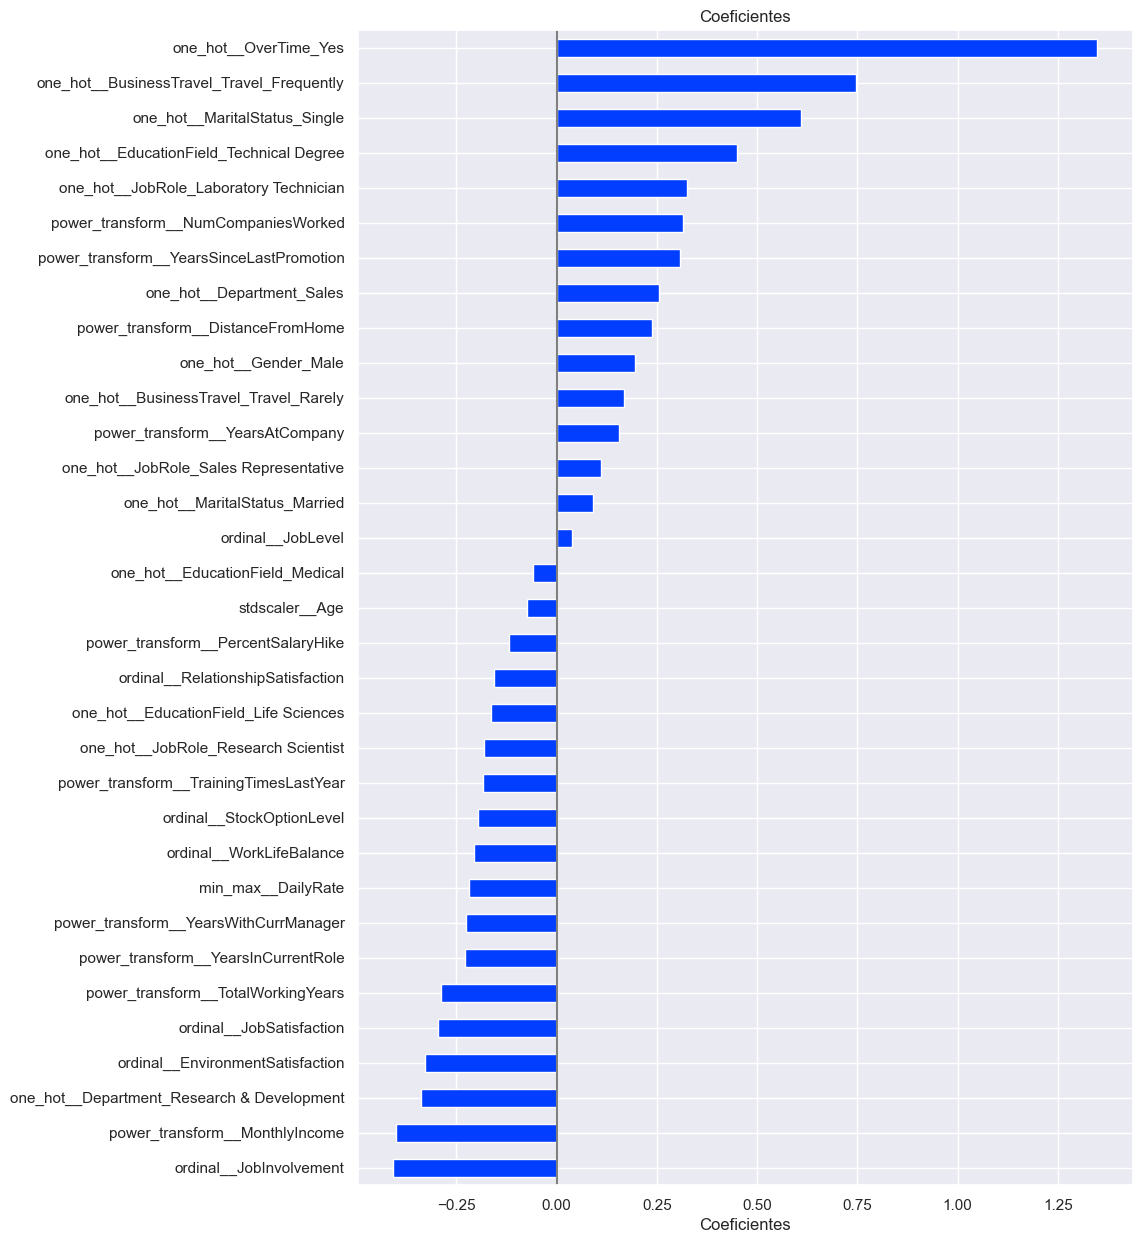

In [34]:
plot_coeficientes(coefs.query('coeficiente !=0'))

**Observações - Correlação não explica causalidade**

- Por exemplo, temos um maior % de Attrition em "solteiros", mas o fato de ser solteiro não quer dizer que as pessoas vão sair da empresa (só que talvez os casados tenham menor probabilidade pois existe a suposição de que podem ter família pra cuidar).

- Podemos destacar sim que Horas Extras e Viagem Frequente tem maior correlação (e não causalidade) com o Attrition.

#### <font color = 'darkblue'> **Transformando os coeficientes de uma regressão logística numa Probabilidade da feature influenciar o target**

##### **Explicação dos Coeficientes de uma Regressão Logística**

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$, variável contínua):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$, variável categórica):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


In [35]:
coefs_odds = coefs.copy()

coefs_odds['coeficiente'] = np.exp(coefs_odds['coeficiente'])

coefs_odds

,coeficiente
ordinal__JobInvolvement,0.664845
power_transform__MonthlyIncome,0.670154
one_hot__Department_Research & Development,0.712327
ordinal__EnvironmentSatisfaction,0.720988
ordinal__JobSatisfaction,0.743072
power_transform__TotalWorkingYears,0.749422
power_transform__YearsInCurrentRole,0.795014
power_transform__YearsWithCurrManager,0.797109
min_max__DailyRate,0.804503
ordinal__WorkLifeBalance,0.814193


In [36]:
coefs_odds.query('coeficiente == 1')     

,coeficiente
min_max__HourlyRate,1.0
ordinal__PerformanceRating,1.0
min_max__MonthlyRate,1.0
ordinal__Education,1.0
one_hot__JobRole_Human Resources,1.0
one_hot__EducationField_Marketing,1.0
one_hot__JobRole_Sales Executive,1.0
one_hot__JobRole_Research Director,1.0
one_hot__JobRole_Manufacturing Director,1.0
one_hot__JobRole_Manager,1.0


OBS: Esses coefs_odds igual a 1 são aqueles cujo coef eram igual a 0 (ou seja, nem aumentam e nem diminuem a chance de mudar o target)

In [ ]:
plot_coeficientes()

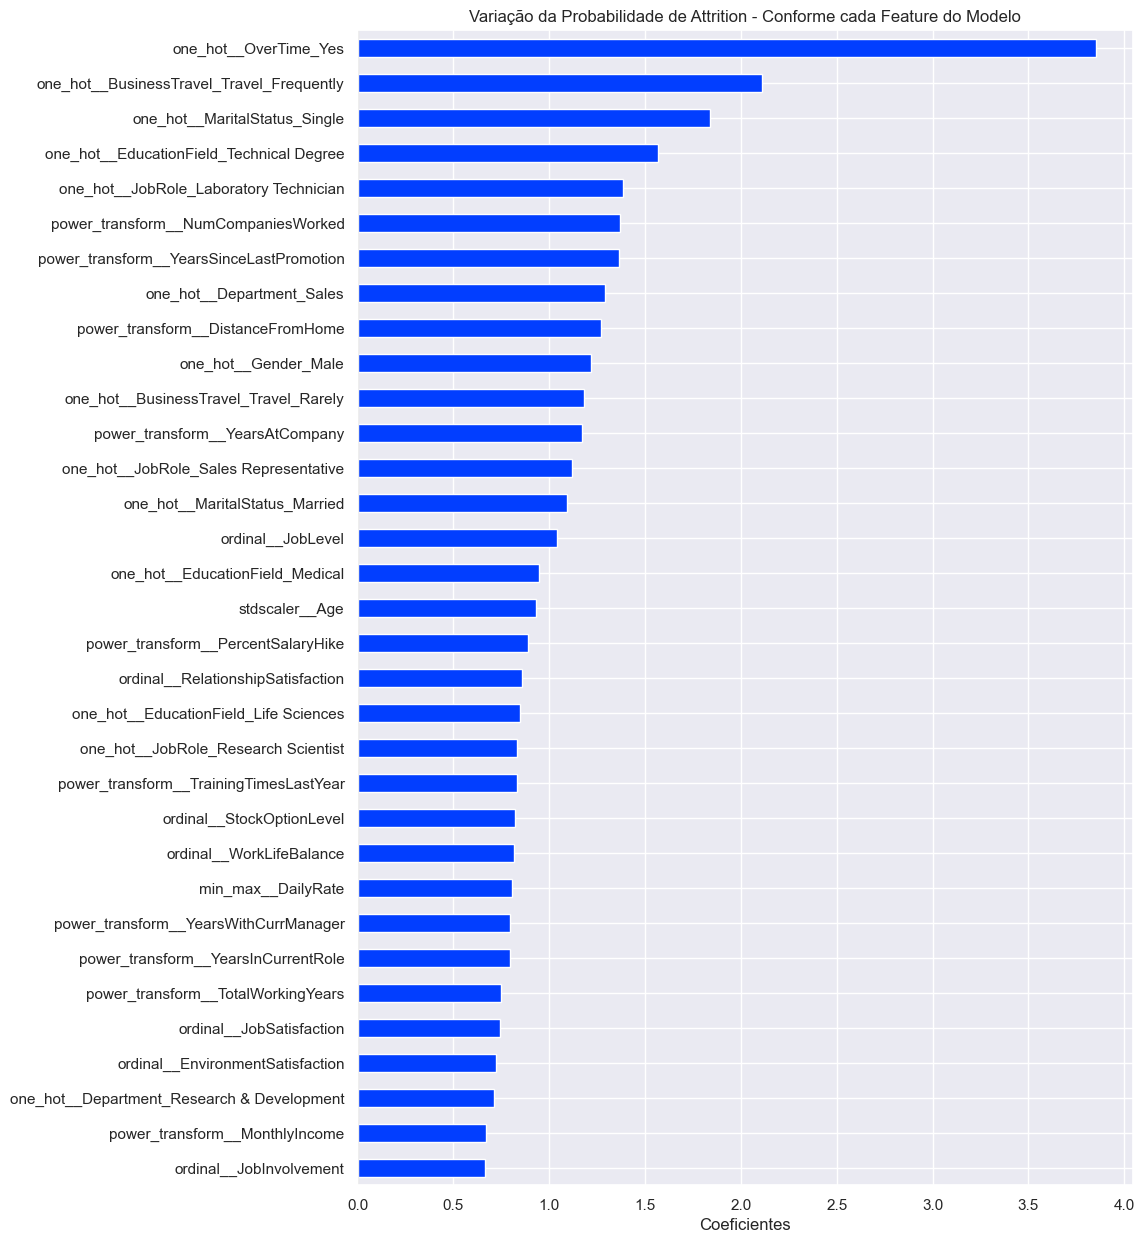

In [50]:
plot_coeficientes(
    coefs_odds.query('coeficiente != 1'), 
    "Variação da Probabilidade de Attrition - Conforme cada Feature do Modelo"
)

##### **Conclusões**
- Podemos ver que os funcionários que fazem hora extra tem 3.5 vezes mais chances de deixar a empresa
- Funcionários que fazem viagens a trabalho tem 2.1 vezes mais chances de deixar a empresa também.
- Funcionários que são solteiros tendem a ter maior probabilidade de sair da empresa quando comparado com funcionários casados (correlação não indica causalidade nesse caso, é só um dado observado)
- Já features relacionadas à satisfação e envolvimento do funcionário na empresa / cargo ajudam a manter os funcionários, assim como o maior renda mensal e a quantidade de anos trabalhando na empresa / cargo.

#### Matriz de Confusão

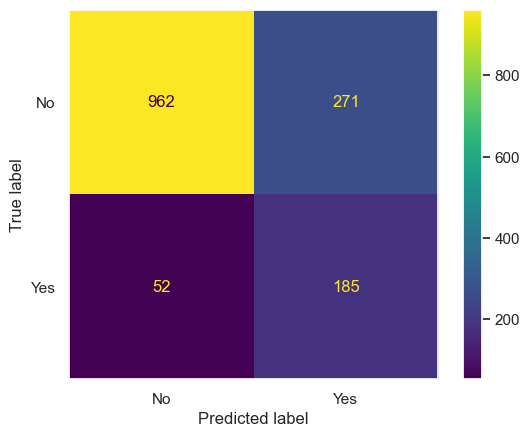

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_
)

plt.grid(False)
plt.show()

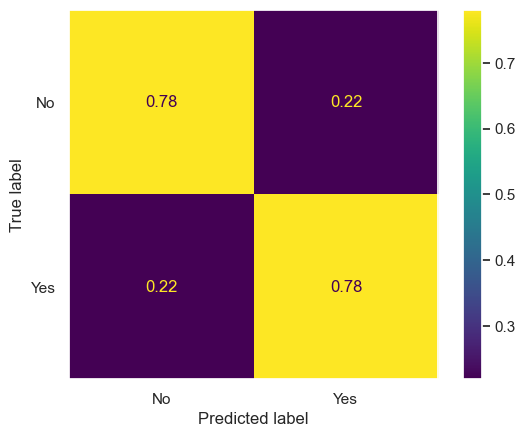

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_,
    normalize='true'
)

plt.grid(False)
plt.show()

#### **Plano de Ação**

- Avaliar os motivos que levam os funcionários a fazerem hora extra que podem influenciar no Attrition
    - Mão de obra insuficiente
    - Falta de organização institucional
    - Falta de treinamento
    - Necessidade de investimento em tecnologia
- Existe a possibilidade de diminuir ou limitar as viagens de negócios?
    - Como isso pode afetar alguns departamentos (ex: vendas)?
    - O que pode tornar as viagens de negócio um motivo para saída da empresa?
- Como a renda mensal de cada setor em nível da empresa se compara ao mercado?
- Quais as ações a empresa pode promover para aumentar o envolvimento e a satisfação do funcionários? Principalmente nos departamentos com maior probabilidade de Attrition 

**OBS**: Analisar as features que mais influenciam o modelo. Destacar features com relação positivas e negativas no estudo feito, ou pro resultado do projeto.

**GITHUB**: Destacar esse plano de ação no GitHub, sintetizando informações importantes do modelo e propondo ações, em algum arquivo / relatório como README, Conclusões, Plano_acao.txt, ou até numa apresentação de PowerPoint do projeto.